In [ ]:
# Import libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gym
import os
import random
from scipy.special import softmax
from IPython.display import HTML

In [ ]:
# Creating environment
env = gym.make('Taxi-v3')

num_actions = env.action_space.n
num_states = env.observation_space.n
row = 5
col = 5

# Actions
SOUTH = 0
NORTH = 1
EAST = 2
WEST = 3
PICK = 4
DROP = 5
total_actions = [SOUTH, NORTH, EAST, WEST, PICK, DROP]
primitive_actions= [SOUTH, NORTH, EAST, WEST]
num_pacts = len(primitive_actions)

# Primary Destinations for Pickup and Drop
RED = 0
GREEN = 1
YELLOW = 2
BLUE = 3
IN_TAXI = 4

passenger_locs = [RED, GREEN, YELLOW, BLUE, IN_TAXI]
destinations = [RED, GREEN, YELLOW, BLUE]
destination_coords = [[0,0], [0,4], [4,0], [4,3]]

num_plocs = len(passenger_locs)
num_dlocs = len(destinations)

# cur_state = ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# Epsilon-greedy policy
def choose_option_action_eg(qvals, num_choices, eps):
    '''
    Choosing the option for the current state
    based on an exploration-exploitation trade-off
    using epsilon-greedy policy
    '''
    if np.random.rand() < eps:
        # Exploration
        option = np.random.choice(num_choices)

    else:
        # Exploitation
        option = np.argmax(qvals)

    return option

def choose_action_eg(qvals, num_pacts, eps):
    '''
    Choosing the action for the current state
    based on an exploration-exploitation trade-off
    using epsilon-greedy policy
    '''
    if np.random.rand() < eps:
        # Exploration
        action = np.random.choice(num_pacts)

    else:
        # Exploitation
        action = np.argmax(qvals)

    return action


In [4]:
def check_passenger_in_taxi(ploc):
    '''
    Checking if passenger in taxi
    '''
    if ploc == 4:
        ptaxi = True
    else:
        ptaxi = False
    return ptaxi

In [8]:
# Defining Options

class Option:
    def __init__(self, desgn_loc, corner):
        self.goal_loc = desgn_loc
        self.corner = corner
        self.qvals = np.zeros((row, col, num_pacts))
        self.sa_freq = np.zeros((row, col, num_pacts))

    def reset(self):
        self.qvals = np.zeros((row, col, num_pacts))
        self.sa_freq = np.zeros((row, col, num_pacts))

    def execute(self, state, ploc, dloc, ptaxi, eps):
        '''
        Choosing primitive action within the option
        and determining option termination

        '''
        dstate = destination_coords[dloc]
        optdone = False

        if state[0] == self.goal_loc[0] and state[1] == self.goal_loc[1]:
            optdone = True
            if self.corner == 0:
                # Top
                if dloc == GREEN:
                    optact = EAST
                else:
                    optact = SOUTH

            if self.corner == 1:
                # Right
                if dloc == GREEN:
                    optact = NORTH
                elif dloc == BLUE:
                    optact = SOUTH
                else:
                    optact = WEST

            if self.corner == 2:
                # Left
                if dloc == RED:
                    optact = NORTH
                elif dloc == YELLOW:
                    optact = SOUTH
                else:
                    optact = EAST

            if self.corner == 3:
                # Middle
                if dloc == GREEN or dloc == BLUE:
                    optact = EAST
                if dloc == RED or dloc == YELLOW:
                    optact = WEST
        else:
            optact = choose_action_eg(self.qvals[state[0], state[1]], num_pacts, eps)

        return optact, optdone

In [17]:
# Learning parameters
gamma = 0.9
alpha = 0.1
num_episodes = 1000
num_runs = 1

eps_decay = 0.99
eps_start = 0.5
eps_final = 0.01

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# Training agent

run_returns = []
run_qo = []
run_options = []

for run in range(num_runs):
    print(f'Beginning Run {run+1}')

    # Creating Options
    Top = Option([0,2], 0)
    Right = Option([2,4], 1)
    Left = Option([2,0], 2)
    Middle = Option([2,2], 3)

    options = [Top, Right, Left, Middle]
    option_names = ['Top', 'Right', 'Left', 'Middle']
    num_options = len(options)

    total_choices = [SOUTH, NORTH, EAST, WEST, Top, Right, Left, Middle, PICK, DROP]

    q_o = np.zeros((num_plocs*num_dlocs, len(total_choices)))

    eps = eps_start

    ep_rew = []

    for ep in range(num_episodes):
        # print(f'\n Episode {ep} begins!\n')
        episode_reward = 0

        # Initial state
        state = env.reset()
        tx, ty, ploc, dloc = list(env.decode(state))
        t_coord = [tx, ty]

        # Checking if passenger is in taxi
        ptaxi = check_passenger_in_taxi(ploc)

        done = False # Episode flag
        steps = 0

        while not done:

            # Get option/action using ep-greedy
            opt_state = num_dlocs*ploc + dloc
            opt_act_id = choose_option_action_eg(q_o[opt_state], len(total_choices), eps)

            if opt_act_id == 8:
                # Pick up passenger
                ptaxi = check_passenger_in_taxi(ploc)

                if not ptaxi:
                    pstate = destination_coords[ploc]
                    if pstate[0] == tx and pstate[1] == ty:
                        action = total_choices[opt_act_id]
                        next_state, reward, done, info = env.step(action)

                        tnx, tny, pnloc, dnloc = list(env.decode(next_state))
                        tn_coord = [tnx, tny]
                        opt_ns = num_dlocs*pnloc + dnloc

                        episode_reward += reward

                        # Update option
                        q_o[opt_state, opt_id] = q_o[opt_state, opt_id] + alpha * (reward + gamma * ((1-done)*q_o[opt_ns, opt_id] +
                                                                                                  done*np.max(q_o[opt_ns,:])) - q_o[opt_state, opt_id])

                        state = next_state
                        tx, ty, ploc, dloc = list(env.decode(state))
                        t_coord = [tx, ty]
                        opt_state = opt_ns

            elif opt_act_id == 9:
                # Drop passenger
                ptaxi = check_passenger_in_taxi(ploc)
                dstate = destination_coords[dloc]
                if ptaxi:
                    if dstate[0] == tx and dstate[1] == ty:
                        action = total_choices[opt_act_id]
                        next_state, reward, done, info = env.step(action)

                        episode_reward += reward

                        # Update option
                        q_o[opt_state, opt_id] = q_o[opt_state, opt_id] + alpha * (reward + gamma * ((1-done)*q_o[opt_ns, opt_id] +
                                                                                                  done*np.max(q_o[opt_ns,:])) - q_o[opt_state, opt_id])

                        state = next_state
                        tx, ty, ploc, dloc = list(env.decode(state))
                        t_coord = [tx, ty]
                        opt_state = opt_ns


            elif opt_act_id < 4:
                # When next action chosen is a primitive action
                opt_id = opt_act_id

                # Get next state, reward, done(episode), info(term prob, action mask)
                action = total_choices[opt_id]
                next_state, reward, done, info = env.step(action)

                tnx, tny, pnloc, dnloc = list(env.decode(next_state))
                tn_coord = [tnx, tny]
                opt_ns = num_dlocs*pnloc + dnloc

                episode_reward += reward

                # Update option
                q_o[opt_state, opt_id] = q_o[opt_state, opt_id] + alpha * (reward + gamma * ((1-done)*q_o[opt_ns, opt_id] +
                                                                                          done*np.max(q_o[opt_ns,:])) - q_o[opt_state, opt_id])


                state = next_state
                tx, ty, ploc, dloc = list(env.decode(state))
                t_coord = [tx, ty]
                opt_state = opt_ns

            else:
                # When next action chosen is an option
                opt_id = opt_act_id
                opt = total_choices[opt_id]
                optdone = False # Option flag

                # Execute option till termination
                while not optdone:
                    steps += 1
                    ptaxi = check_passenger_in_taxi(ploc)
                    # Get primitive action, optact and optdone
                    optact, optdone = opt.execute([tx, ty], ploc, dloc, ptaxi, eps)

                    # Get next state, reward, done(episode), info(term prob, action mask)
                    next_state, reward, done, info = env.step(optact)

                    tnx, tny, pnloc, dnloc = list(env.decode(next_state))
                    tn_coord = [tnx, tny]
                    opt_ns = num_dlocs*pnloc + dnloc
                    # print([tx,ty], [tnx,tny], reward, optdone, done, ploc, dloc, pnloc, dnloc)

                    episode_reward += reward

                    # Update primitive actions
                    if optact < 4:
                        opt.qvals[tx, ty, optact] = opt.qvals[tx, ty, optact] + alpha * (reward + gamma*np.max(opt.qvals[tnx, tny]) - opt.qvals[tx, ty, optact])
                        opt.sa_freq[tx, ty, optact] += 1
                    if optdone and optact < 4:
                        opt.sa_freq[tnx, tny, optact] += 1

                    # Update option
                    q_o[opt_state, opt_id] = q_o[opt_state, opt_id] + alpha * (reward + gamma * ((1-optdone)*q_o[opt_ns, opt_id] +
                                                                                          optdone*np.max(q_o[opt_ns,:])) - q_o[opt_state, opt_id])

                    # Updating consistent options
                    for op in range(4, 4+num_options):
                        if opt_id != op:
                            other_opt = total_choices[op]
                            optact_, optdone_ = other_opt.execute([tx, ty], ploc, dloc, ptaxi, eps)
                            if optact_ == optact:
                                q_o[opt_state, op] = q_o[opt_state, op] + alpha * (reward + gamma * ((1-optdone_)*q_o[opt_ns, op] +
                                                                                              optdone_*np.max(q_o[opt_ns,:])) - q_o[opt_state, op])

                    state = next_state
                    tx, ty, ploc, dloc = list(env.decode(state))
                    t_coord = [tx, ty]
                    opt_state = opt_ns


        eps = max(eps_final, eps_decay*eps)
        ep_rew.append(episode_reward)
        ep_rew_avg100 = [np.average(ep_rew[i:i+100]) for i in range(len(ep_rew)-100)]

    print(f'Run: {run+1} - Max reward: {max(ep_rew)}')
    run_returns.append(ep_rew)
    run_qo.append(q_o)
    run_options.append([Top, Right, Left, Middle])

Beginning Run 1
Run: 1 - Max reward: 9


In [ ]:
plt.plot(ep_rew)

In [ ]:
returns_mean = np.mean(run_returns, 0)
plt.plot(returns_mean)
plt.xlabel('Episodes')
plt.ylabel('Episodic Returns')
plt.title('IntraOption Q-Learning (Episodic Returns averaged over 5 runs)')

In [ ]:
xvals = range(200,1500)
plt.plot(xvals,returns_mean[200:1500])
plt.xlabel('Episodes')
plt.ylabel('Episodic Returns')
plt.title(f'IntraOption Q-Learning (Episodic Returns averaged over 5 runs)\n200th-1500th episode to visualize exact reward values')

In [ ]:
max(returns_mean)

11.0

In [ ]:
return_avg100 = [np.average(returns_mean[i:i+100]) for i in range(len(returns_mean)-100)]

In [ ]:
plt.plot(return_avg100)
plt.xlabel('Episodes')
plt.ylabel('Episodic Returns (averaged every 100 episodes)')
plt.title('IntraOption Q-Learning (Episodic Returns averaged over 5 runs)')

In [ ]:
max(return_avg100)

In [ ]:
xvals = range(200,1400)
plt.plot(xvals,return_avg100[200:1400])
plt.xlabel('Episodes')
plt.ylabel('Episodic Returns (averaged every 100 episodes)')
plt.title(f'IntraOption Q-Learning (Episodic Returns averaged over 5 runs)\nFrom 200th episode to visualize exact reward values')

In [ ]:
results_trial_dict = {'Returns': run_returns, 'Q_o': run_qo, 'Options': run_options}

In [ ]:
with open('trial2.pkl', 'wb') as f:
    pickle.dump(results_trial_dict, f)

In [19]:
def plotQvals(Q, message = "Q plot"):
    # Visualize Q values across taxi env
    Q = np.flip(Q, 0)
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [NORTH, SOUTH]:
            return 0
        return 1 if a == EAST else -1
    def y_direct(a):
        if a in [EAST, WEST]:
            return 0
        return 1 if a == NORTH else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.show()

<Figure size 3600x1800 with 0 Axes>

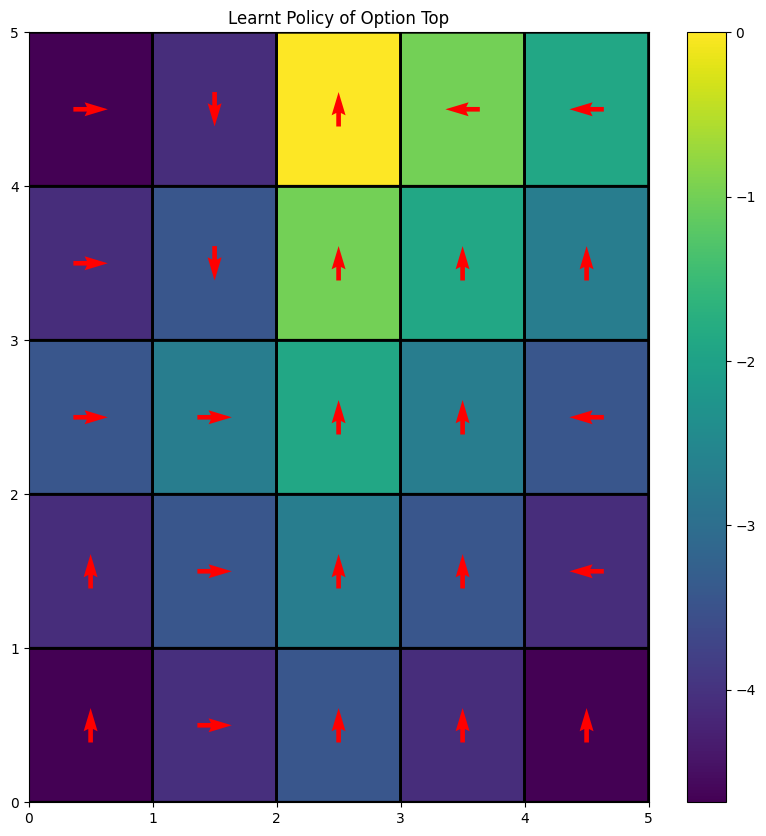

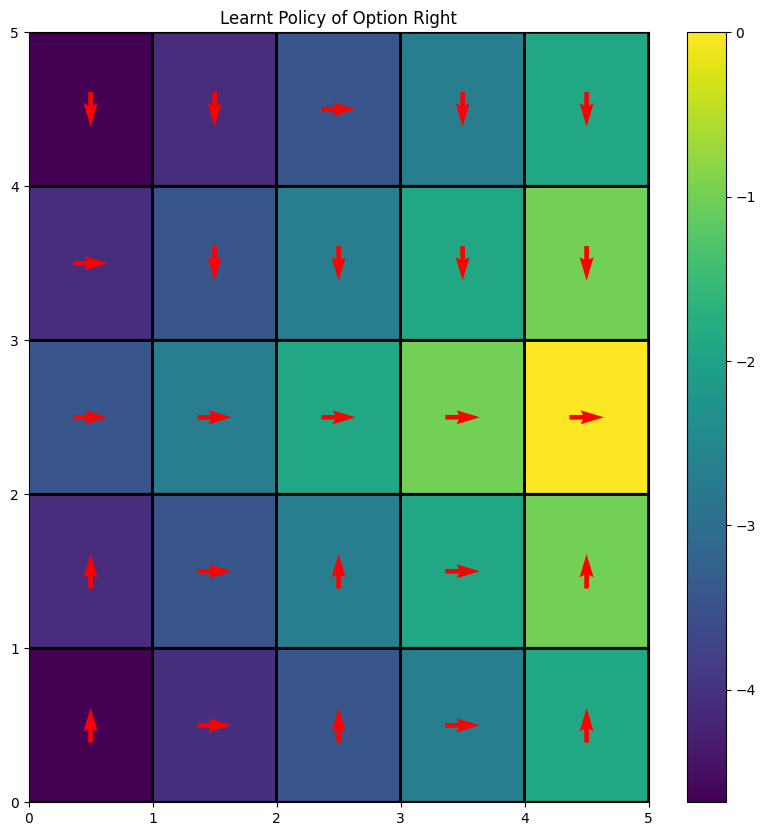

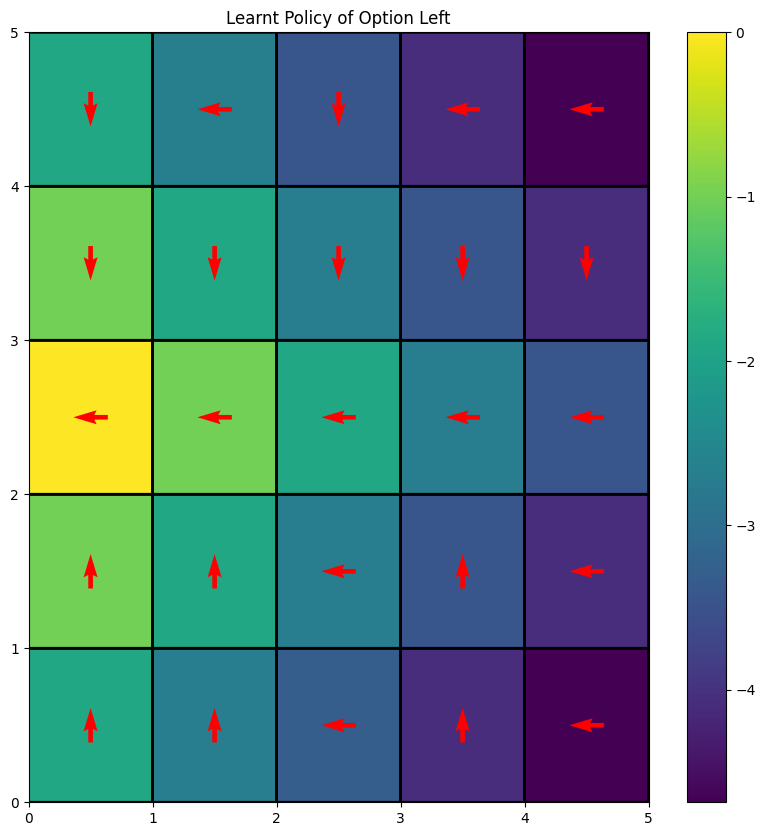

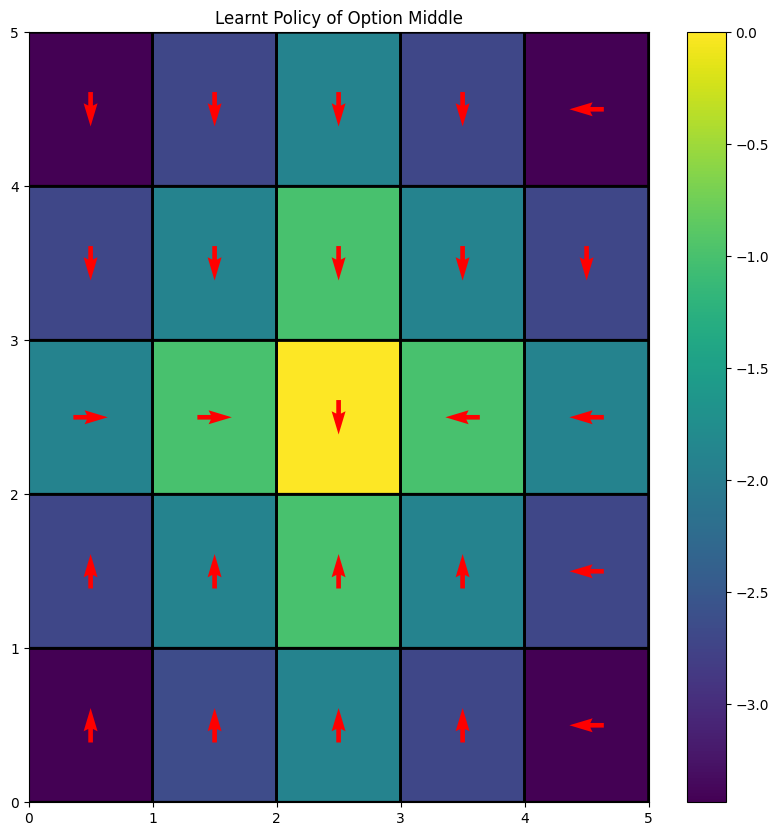

In [21]:
fig = plt.figure(figsize=(12, 6), dpi=300)
# fig.title('Q value visualization for the Option policies')
f1 = plotQvals(Top.qvals, 'Learnt Policy of Option Top')
f2 = plotQvals(Right.qvals, 'Learnt Policy of Option Right')
f3 = plotQvals(Left.qvals, 'Learnt Policy of Option Left')
f4 = plotQvals(Middle.qvals, 'Learnt Policy of Option Middle')